In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

## Some stocks traded on the market

In [ ]:
df = pd.read_csv("stock_details_5_years.csv")
df = df.sort_values(by=['Company', 'Date'])

def adjust_company_prices(df_company):
    # Sort by date descending to compute cumulative factors from most recent to oldest.
    df_company = df_company.sort_values(by='Date', ascending=False).copy()

    # Replace missing or 0 splits with 1.
    df_company['split_factor'] = df_company['Stock Splits'].replace(0, 1)

    # Compute dividend factor; if Dividend is 0, factor is 1.
    df_company['div_factor'] = np.where(df_company['Dividends'] == 0,
                                        1,
                                        (df_company['Close'] - df_company['Dividends']) / df_company['Close'])

    # Combined adjustment factor for each day.
    df_company['adj_factor'] = df_company['split_factor'] * df_company['div_factor']

    # Compute cumulative product of the adjustment factors.
    # This gives the adjustment factor to apply to prices on each date.
    df_company['cum_adj'] = df_company['adj_factor'].cumprod()

    # Adjust the prices.
    for col in ['Open', 'High', 'Low', 'Close']:
        df_company[f'Adj_{col}'] = df_company[col] * df_company['cum_adj']

    # Return to original order if needed.
    return df_company.sort_values(by='Date')

# Apply the function to each company.
df_adjusted = df.groupby('Company').apply(adjust_company_prices).reset_index(drop=True)
df_adjusted = df_adjusted.sort_values(by=['Company', 'Date'])

# Compute daily returns using groupby and pct_change
df_adjusted['Daily_Return'] = df_adjusted.groupby('Company')['Adj_Close'].pct_change()

df_adjusted['Date'] = pd.to_datetime(df_adjusted['Date'], errors='coerce', utc=True)
df_adjusted['Date'] = pd.to_datetime(df_adjusted['Date'].dt.date)


# Pivot the table so that dates are the index and companies are columns.
df_returns_pivot = df_adjusted[['Date', 'Company', 'Daily_Return']].pivot(index='Date', columns='Company', values='Daily_Return')


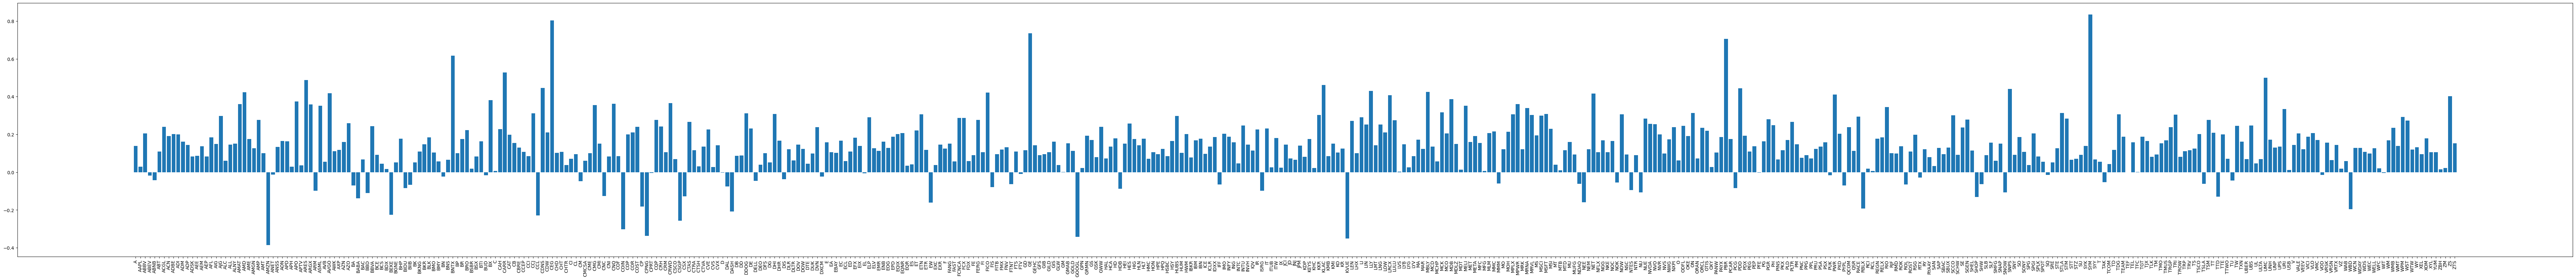

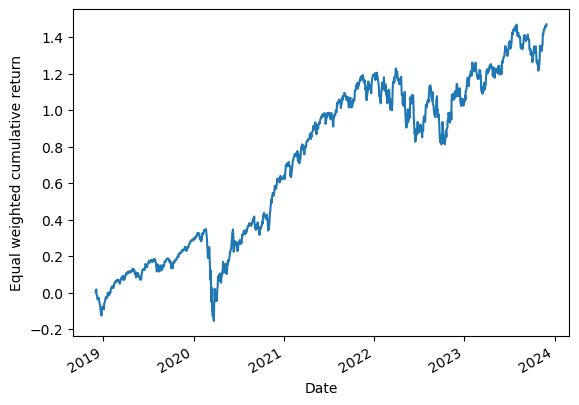

In [ ]:
## annualized return and covariance
mu = (1 +df_returns_pivot).prod() ** (252 / df_returns_pivot.count()) - 1
cov = df_returns_pivot.cov()

mu=mu.values
cov=cov.values

labels = df_returns_pivot.columns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(100, 10))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()


f = plt.figure(figsize=(100, 100))
plt.matshow(df_returns_pivot.corr(), fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

cum_ret=(1 + df_returns_pivot.mean(1)).cumprod()-1
cum_ret.plot()
plt.ylabel('Equal weighted cumulative return')
plt.show()

### Optimization

In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize
from pymoo.termination import get_termination

class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0.005, **kwargs):
        super().__init__(n_var=len(mu), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        #x is a normalized vector accounting for the portfolio weights I'm allocating in each asset
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk
        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe


from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-5] = 0
        return X / X.sum(axis=1, keepdims=True)



In [ ]:
## annualized return and covariance
mu = (1 + df_returns_pivot).prod() ** (252 / df_returns_pivot.count()) - 1
cov = df_returns_pivot.cov()

mu=mu.values
cov=cov.values


problem = PortfolioProblem(mu, cov)

algorithm = SMSEMOA(repair=PortfolioRepair())
termination = get_termination("n_gen", 100)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               verbose=False)

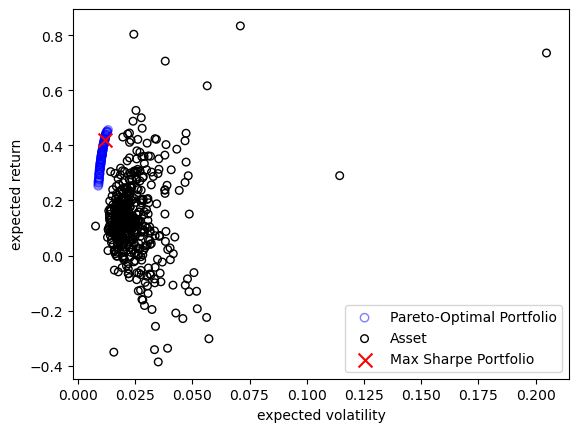

In [ ]:
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

## "Realistic" strategy

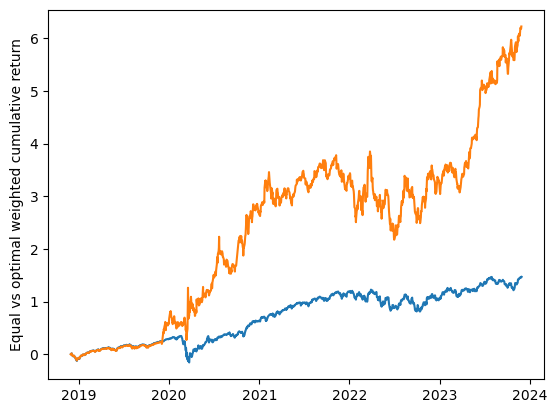

In [ ]:

reallocation_dates=['2018-11-29','2019-11-29','2020-11-29','2021-11-29','2022-11-29','2023-11-29']

returns=[]
weights=np.ones(len(df_returns_pivot.columns))/len(df_returns_pivot.columns)

for i in range(1,len(reallocation_dates)):
    train_df=df_returns_pivot.loc[(df_returns_pivot.index <reallocation_dates[i])&(df_returns_pivot.index >=reallocation_dates[i-1])]
    port_ret=(np.expand_dims(weights,0)*train_df).sum(1)

    returns.append(pd.DataFrame(port_ret,index=train_df.index,columns=['return']))

    if i != len(reallocation_dates):
        mu = (1 + train_df).prod() ** (252 / train_df.count()) - 1
        cov = train_df.cov()

        mu=mu.values
        cov=cov.values


        problem = PortfolioProblem(mu, cov)

        algorithm = SMSEMOA(repair=PortfolioRepair())
        termination = get_termination("n_gen", 100)

        res = minimize(problem,
                    algorithm,
                    termination=termination,
                    seed=1,
                    verbose=False)

        X, F, sharpe = res.opt.get("X", "F", "sharpe")
        max_sharpe = sharpe.argmax()

        weights=X[max_sharpe]

returns=pd.concat(returns)




cum_ret_EW=(1 + df_returns_pivot.mean(1)).cumprod()-1
cum_ret_opt=(1 + returns).cumprod()-1
plt.plot(cum_ret_EW)
plt.plot(cum_ret_opt)
plt.ylabel('Equal vs optimal weighted cumulative return')
plt.show()